In [93]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import Explore as Ex
import plotly
from plotly.graph_objs import Scatter, Layout
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from pivottablejs import pivot_ui
import Imputation as Im

In [94]:
dataset = pd.read_csv('../Arthena/task/data.csv',encoding="latin-1")

### Data Cleaning

#### Drop rows without hammer_price column value at the initial attempt

In [95]:
dataset = dataset.drop(dataset[dataset.hammer_price.isnull()].index)

#### Check the missing value of each column

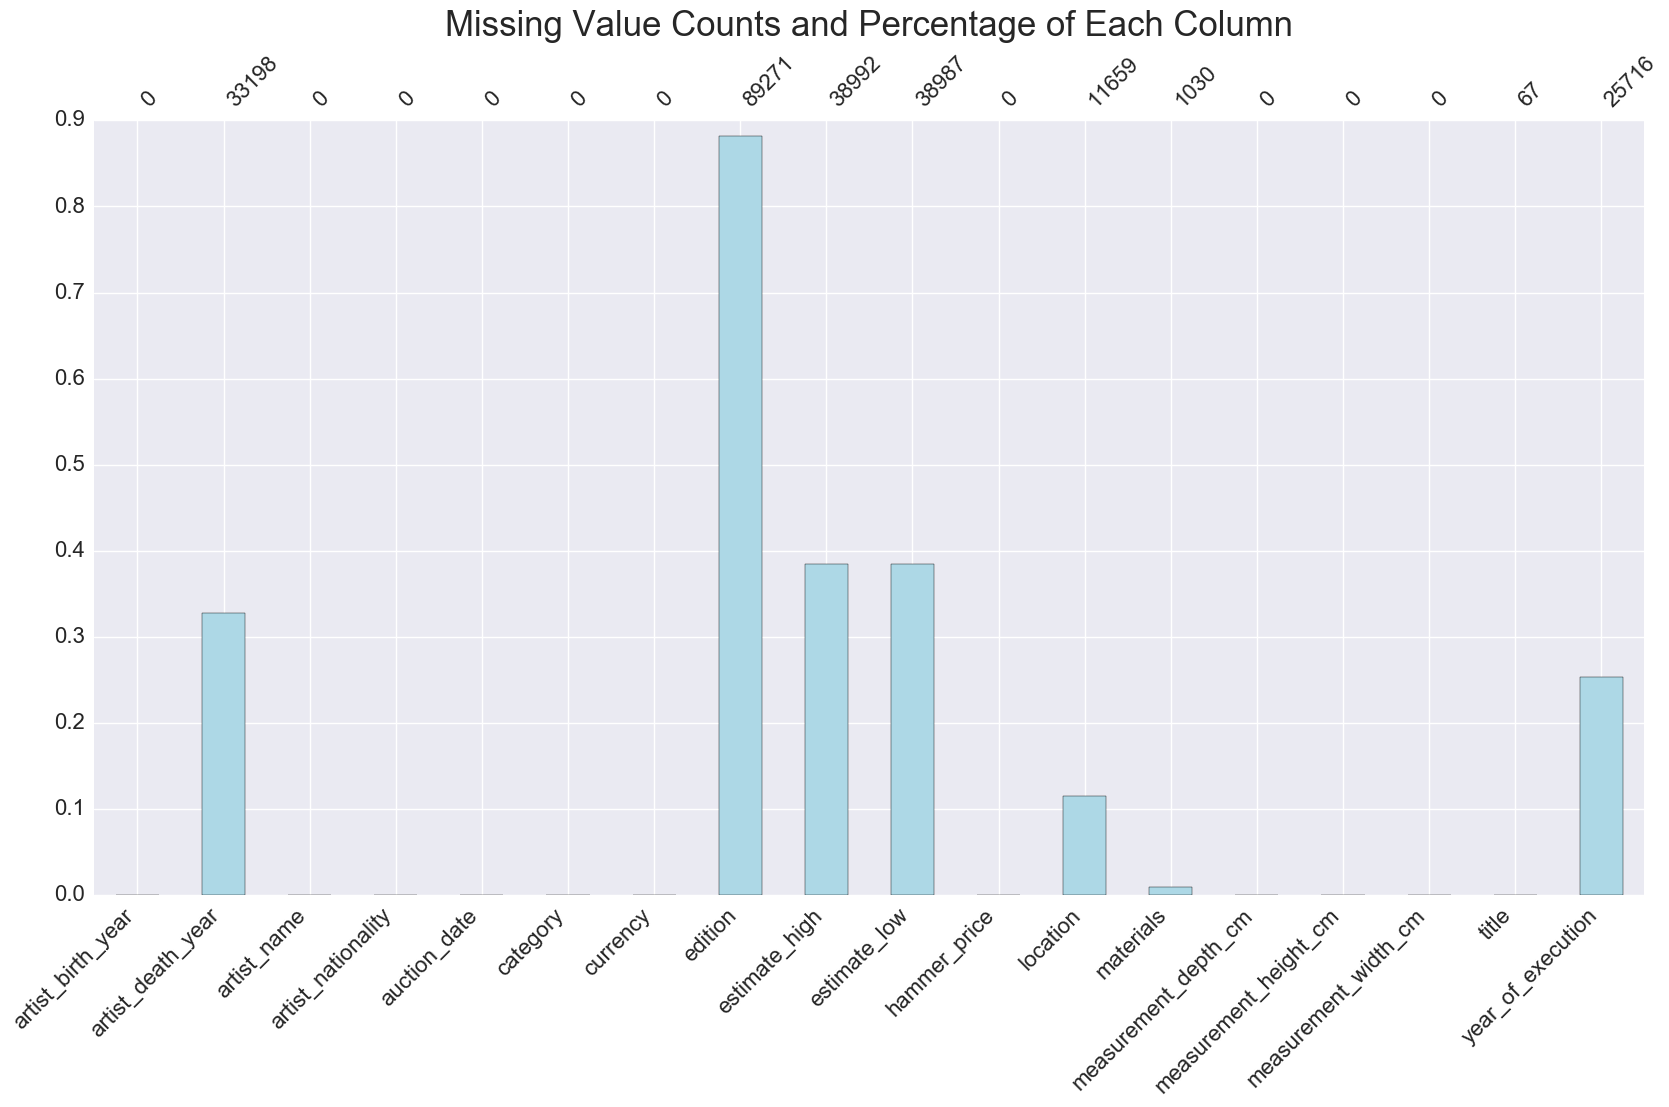

In [96]:
Ex.missing_value_bar(dataset,color="lightblue",title_string = "Missing Value Counts and Percentage of Each Column")

#### Drop column with 50% of missing value

In [97]:
check_null = dataset.isnull().sum(axis=0).sort_values(ascending=False)/float(len(dataset))
dataset.drop(check_null[check_null>0.5].index, axis=1, inplace=True)
drop_column = check_null[check_null>0.5].index.tolist()

#### Check how unique the each column is 

In [98]:
counts = np.array([len(dataset[col].value_counts()) for col in dataset.columns])
counts

array([   70,    43,   119,    17,  5153,    15,     3,   264,   243,
        1646,   217, 12257,   197,   396,   475, 35347,   988])

#### Remove Columns with little information
* `measurement_depth_cm` is 0 for 91.52% of the records (Drop for now and may categorize it later)
* `title` provides little information right now.(May be useful to do some NLP)

In [99]:
delete_me = ['measurement_depth_cm','title']
drop_column = drop_column + delete_me
dataset.drop(delete_me , axis=1, inplace=True) 

### Feature transformations

#### Modify the `year_of_execution` column

In [100]:
len(dataset['year_of_execution'].value_counts())

988

In [101]:
dataset['year_of_execution'] = dataset.year_of_execution.str.extract(r"(\d{4})")

/Users/chenchaozang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



In [102]:
len(dataset['year_of_execution'].value_counts())

212

In [103]:
dataset.ix[pd.to_numeric(dataset['year_of_execution'])>2016,'year_of_execution'] = '2016'

#### Drop the `estimate_high` and `estimate_low` columns
* Over 30% of records are missing in estimate_high and estimate_low
* These two columns may lead to information leakage

In [104]:
dataset.drop('estimate_high' , axis=1, inplace=True)
dataset.drop('estimate_low' , axis=1, inplace=True) 
drop_column.append('estimate_high')
drop_column.append('estimate_low')

#### Modify the auction date

In [105]:
dataset['auction_year'] = dataset['auction_date'].str.split('-').str[0]
dataset['auction_month'] = dataset['auction_date'].str.split('-').str[1]
# dataset.ix[dataset.auction_month>'06','auction_month'] = 'Fall'
# dataset.ix[dataset.auction_month<='06','auction_month'] = 'Spring'
dataset.drop('auction_date' , axis=1, inplace=True) 
drop_column.append('auction_date')

In [15]:
dataset.dtypes

artist_birth_year          int64
artist_death_year        float64
artist_name               object
artist_nationality        object
category                  object
currency                  object
hammer_price             float64
location                  object
materials                 object
measurement_height_cm      int64
measurement_width_cm       int64
year_of_execution         object
auction_year              object
auction_month             object
dtype: object

#### Get the artist age

In [16]:
dataset.ix[dataset.artist_death_year.isnull(),'artist_death_year'] = 2013
dataset['artist_age'] = dataset.artist_death_year - dataset.artist_birth_year
dataset.drop('artist_birth_year' , axis=1, inplace=True)
dataset.drop('artist_death_year' , axis=1, inplace=True)
drop_column.append('artist_birth_year')
drop_column.append('artist_death_year')

#### Get the period between auction `year` and `year_of_execution`

#### Drop the material column first

#### Solution to work on `material` column

* For non-linear algorithms like RF you can also replace a categorical variable by the number of times it appears in the train set. This turns it into a single feature.

In [17]:
dataset.drop('materials' , axis=1, inplace=True)
drop_column.append('materials')

In [18]:
# dataset['materials'] = dataset['materials'].str.lower()
# dataset['materials'] = dataset['materials'].str.strip('.')
# dataset['materials'] = dataset['materials'].str.strip(',')

In [19]:
# dataset.materials.value_counts()[dataset.materials.value_counts()>50]

In [20]:
# fracs = dataset.materials.value_counts()[dataset.materials.value_counts()>50].tolist()
# labels = dataset.materials.value_counts()[dataset.materials.value_counts()>50].index.tolist()

In [21]:
# plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

### Data Exploration

In [22]:
# pivot_ui(dataset.sample(frac=0.1))

In [23]:
price = dataset.hammer_price
data = dataset.drop("hammer_price", axis=1)
drop_column.append('hammer_price')

In [24]:
from sklearn.model_selection import train_test_split
data_train, data_test, price_train, price_test = train_test_split(
    data,  price, random_state=1)

In [25]:
data_train_imputation = Im.imputation(data_train)

In [26]:
data_train_imputation.isnull().any()

artist_name              False
artist_nationality       False
category                 False
currency                 False
location                 False
year_of_execution        False
auction_year             False
auction_month            False
measurement_height_cm    False
measurement_width_cm     False
artist_age               False
dtype: bool

In [27]:
plotly.offline.init_notebook_mode(connected=True)

In [28]:
py.iplot(Ex.draw_pie(dataset,'category'))

In [29]:
py.iplot(Ex.draw_pie(dataset,'location'))

In [30]:
py.iplot(Ex.draw_pie(dataset,'currency'))

In [32]:
py.iplot(Ex.draw_pie(dataset,'artist_nationality'))

In [33]:
# import pickle
# with open('drop_column', 'wb') as out_pickle:
#     pickle.dump(drop_column, out_pickle)

In [34]:
# with open('data_train_columns', 'wb') as out_pickle:
#     pickle.dump(data_train_dummies.columns, out_pickle)

In [35]:
data_train_dummies = pd.get_dummies(data_train_imputation)

In [36]:
data_test_imputation = Im.imputation(data_test)

In [39]:
data_test_dummies = pd.get_dummies(data_test_imputation)
for column in data_train_dummies.columns:
    if (column not in data_test_dummies.columns):
        data_test_dummies[column] = pd.Series(0, index=data_test_dummies.index)
for column in data_test_dummies.columns:
    if (column not in data_train_dummies.columns):
        data_test_dummies.drop(column,axis=1,inplace=True)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Initialize the model class.
model = LinearRegression()
# Fit the model to the training data.
model.fit(data_train_dummies, price_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
# Generate our predictions for the test set.
predictions = model.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

717178.53902256419

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3).fit(data_train_dummies, price_train)

In [43]:
# Generate our predictions for the test set.
predictions = rf.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

1675228.7435732333

In [44]:
from sklearn.linear_model import RidgeCV
rf = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(
    data_train_dummies, price_train)

In [45]:
# Generate our predictions for the test set.
predictions = rf.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

690107.31120052701

In [131]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.pipeline import make_pipeline 
from sklearn.feature_selection import f_regression
pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=30), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))

In [ ]:
pipe.fit(data_train_dummies, price_train)
# Generate our predictions for the test set.
predictions = pipe.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

(0, 50)

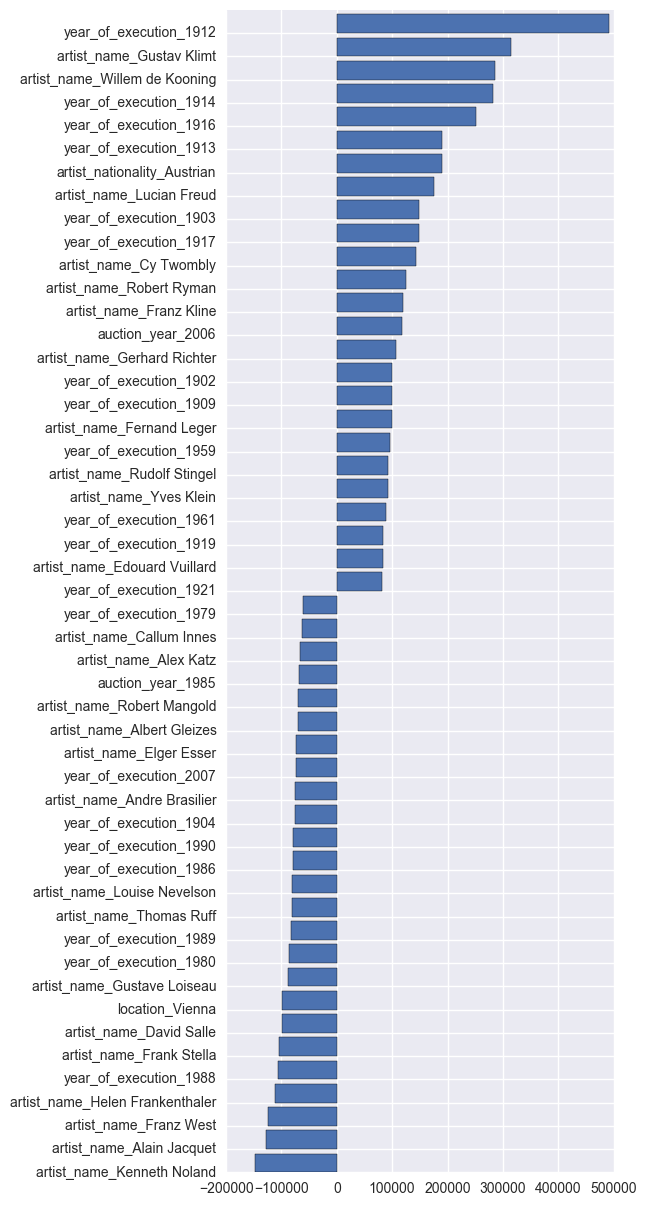

In [46]:
top_n = 50
coef = rf.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), coef[inds])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds])
plt.ylim(0, top_n)

In [47]:
from sklearn.linear_model import Ridge
rf = Ridge().fit(
    data_train_dummies, price_train)

In [48]:
# Generate our predictions for the test set.
predictions = rf.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

713061.49149636691

In [49]:
from sklearn.linear_model import LassoLarsCV
rf = LassoLarsCV().fit(
    data_train_dummies, price_train)

/Users/chenchaozang/anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=3.871e+01, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.220e-16

/Users/chenchaozang/anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=2.719e+01, with an active set of 70 regressors, and the smallest cholesky pivot element being 1.054e-08

/Users/chenchaozang/anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 87 iterations, i.e. alpha=2.318e+01, with an active set of 87 regressors, and the smallest cholesky pivot element being 1.490e-08

/Users/chenchaozang/anaconda/lib/python3.5/site-package

In [50]:
# Generate our predictions for the test set.
predictions = rf.predict(data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, price_test))

702439.54025666614

In [ ]:
# Save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(rf, open(filename, 'wb'))
# predict('../Arthena/task/data.csv')

### Required Questions

#### Which features are most important for your model? Are there any that surprised to you?

According to the coefficient graph, the year of execution and artist name seems important to the price. Surprisingly, other factors like category and size of works do not pop out at all.

#### How would you determine the relationship between the size of works and their price?

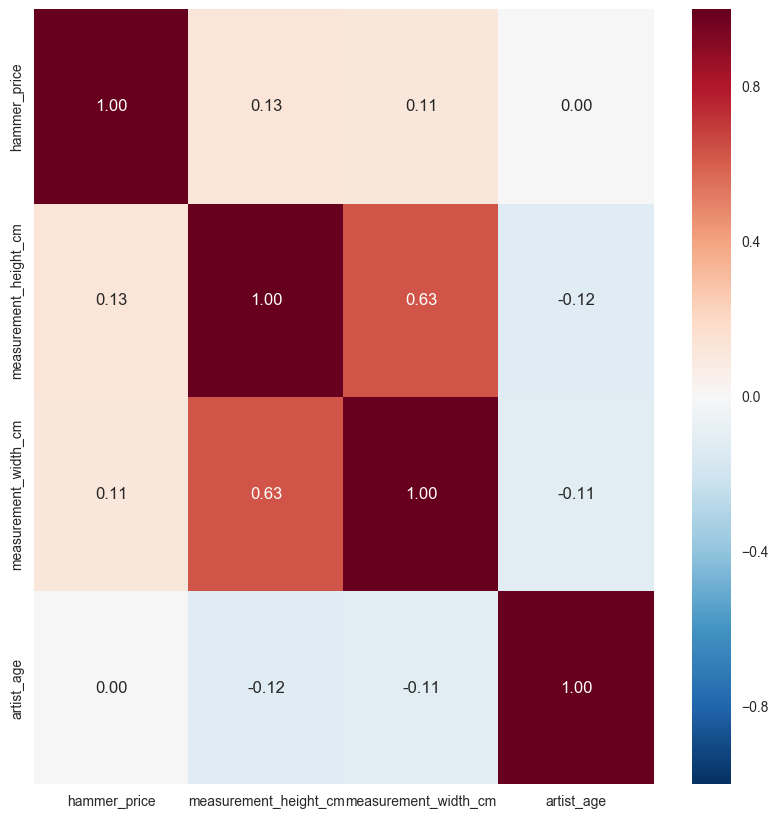

In [51]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,10))  
corr = dataset[dataset.columns[dataset.dtypes != "object"]].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True, fmt=".2f", ax = ax)

#### How would you predict the price of a work if you were only given the artist name, type of work, and size?

In [53]:
part_data = data.ix[:,['artist_name','category','measurement_height_cm','measurement_width_cm']]

In [57]:
part_data_train, part_data_test, part_price_train, part_price_test = train_test_split(
    part_data, price, random_state=1)

In [59]:
part_data_train_dummies = pd.get_dummies(part_data_train)
part_data_test_dummies = pd.get_dummies(part_data_test)
for column in part_data_train_dummies.columns:
    if (column not in part_data_test_dummies.columns):
        part_data_test_dummies[column] = pd.Series(0, index=part_data_test_dummies.index)
for column in part_data_test_dummies.columns:
    if (column not in part_data_train_dummies.columns):
        part_data_test_dummies.drop(column,axis=1,inplace=True)

In [60]:
from sklearn.linear_model import RidgeCV
rf = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(
    part_data_train_dummies, part_price_train)
# Generate our predictions for the test set.
predictions = rf.predict(part_data_test_dummies)

# Compute error between our test predictions and the actual values.
np.sqrt(mean_squared_error(predictions, part_price_test))

682664.37359268987

#### What happened to works by Sol Lewitt before, during and after the 2007-2008 financial crisis. How quickly did prices return to pre-2008 levels?

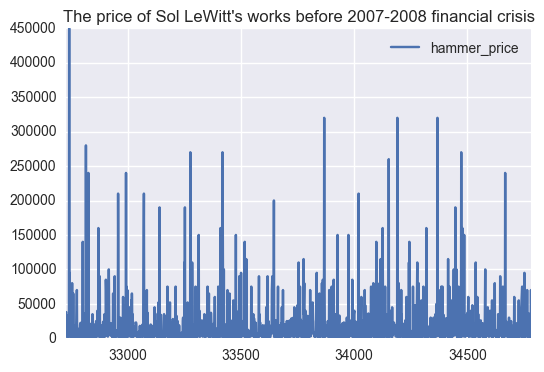

In [112]:
dataset[dataset.artist_name == 'Sol LeWitt'].ix[pd.to_numeric(dataset['auction_year'])<2007,['hammer_price']].plot(title = "The price of Sol LeWitt's works before 2007-2008 financial crisis")

In [117]:
dataset[dataset.artist_name == 'Sol LeWitt'].ix[pd.to_numeric(dataset['auction_year'])<2007,['hammer_price']].mean()

hammer_price    17455.922948
dtype: float64

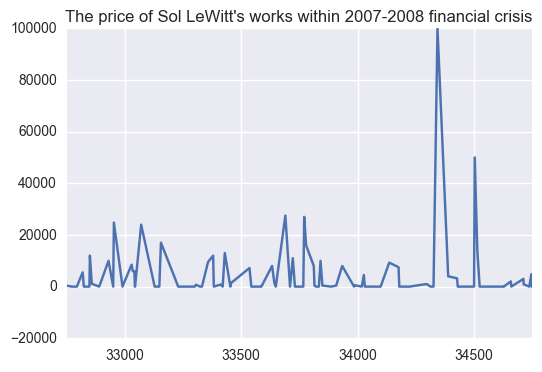

In [115]:
dataset[dataset.artist_name == 'Sol LeWitt'].ix[(pd.to_numeric(dataset['auction_year'])==2008)|(pd.to_numeric(dataset['auction_year'])==2007),'hammer_price'].plot(title = "The price of Sol LeWitt's works within 2007-2008 financial crisis")

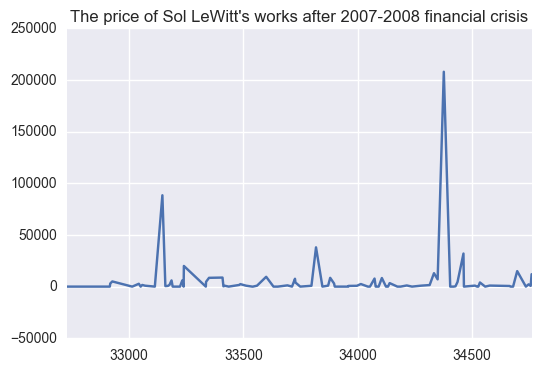

In [116]:
dataset[dataset.artist_name == 'Sol LeWitt'].ix[pd.to_numeric(dataset['auction_year'])>2008,'hammer_price'].plot(title = "The price of Sol LeWitt's works after 2007-2008 financial crisis")

In [129]:
dataset[dataset.artist_name == 'Sol LeWitt'].ix[(pd.to_numeric(dataset['auction_year'])>2008)&(dataset['hammer_price']>17455.922948),:]

,artist_birth_year,artist_death_year,artist_name,artist_nationality,category,currency,hammer_price,location,materials,measurement_height_cm,measurement_width_cm,year_of_execution,auction_year,auction_month
33146,1928,2007.0,Sol LeWitt,American,Unclassified,USD,88400.0,NaN,Painted wood.,96,201,1986,2010,11
33240,1928,2007.0,Sol LeWitt,American,Photograph,USD,20000.0,NaN,"The complete set of 12 gelatin silver prints, ...",27,27,1998,2013,10
33818,1928,2007.0,Sol LeWitt,American,Etching,USD,38000.0,NaN,"The complete set of 12 etchings, on Magnani pa...",50,65,1990,2014,10
34377,1928,2007.0,Sol LeWitt,American,Unclassified,USD,207917.0,NaN,A wall divided into four parts based on archit...,0,0,1970,2009,05
34463,1928,2007.0,Sol LeWitt,American,Unclassified,EUR,32000.0,Paris,screen composed of five panels,183,76,1988,2009,12


##### We can get some conclusions by comparing above plots:

* The number of works being purchased during auction was significantly dropped since the financial crisis.
* The hammer price of works decreased a lot since the financial crisis.

##### How quickly did prices return to pre-2008 levels?

Here, I consider the average hammer price as the pre-2008 level. I looked the auction date of the work whose hammer price is larger or equal than the pre-2008 level to evaluate how quickly the price return to pre-2008 level.

Indeed, in an auction held in May 2009, it is the first time that the price of Sol LeWitt's work returns to pre-2008 level.

#### What additional data or features do you think would help increase performance?

I think there are a couple things that we can do to improve our model's performance.

* We can apply NLP techniques on the description and interpretation of the art works and generate some quantitive feature. Therefore, these feature may help us articulate the work comprehensively.

* We can conduct the sentimemnt analysis on some comments, news and opnions about the artist, the category of art. By using the NLP techniques, we will be able to let the model to understand the art work market.

* As we can see from previous question, the hammer price of an artist could be significantly influenced by economic factors and this relationship is pretty reasonable and straightforward. Therefore, including some economic data might be another direction that we can take a look at.